<a href="https://colab.research.google.com/github/imrealhelper/Aerospace_experiment_2/blob/main/3%EC%A0%90%EA%B5%BD%ED%9E%98%EC%8B%9C%ED%97%98_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 전처리

In [120]:
import pandas as pd
from urllib.parse import quote

base = "https://raw.githubusercontent.com/imrealhelper/Aerospace_experiment_2/main/"
fname = "굽힘시험 수직 raw.csv"
url = base + quote(fname)  # 공백/한글을 %로 인코딩

df1 = pd.read_csv(url, encoding="cp949")   # 또는 "utf-8-sig"
df1 = df1.iloc[1:]
display(df1)

,일련번호,시간,하중,변위,테이블,강도,변형율
1,1.0,0.000,0.0000,0.000000,0.001700,0.0000,0.000000
2,2.0,0.008,0.0000,0.002100,0.002100,0.0000,0.001406
3,3.0,0.025,0.0000,0.002400,0.002400,0.0000,0.001607
4,4.0,0.041,0.0000,0.002800,0.002800,0.0000,0.001875
5,5.0,0.057,0.0000,0.003200,0.003200,0.0000,0.002143
...,...,...,...,...,...,...,...
18826,18826.0,301.519,0.0178,7.468600,7.468600,0.0094,5.001295
18827,18827.0,301.535,0.0184,7.468900,7.468900,0.0097,5.001496
18828,18828.0,301.551,0.0184,7.469300,7.469300,0.0097,5.001763
18829,18829.0,301.569,0.0178,7.469700,7.469700,0.0094,5.002031


In [121]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18830 entries, 1 to 18830
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일련번호    18830 non-null  float64
 1   시간      18830 non-null  object 
 2   하중      18830 non-null  object 
 3   변위      18830 non-null  object 
 4   테이블     18830 non-null  object 
 5   강도      18830 non-null  object 
 6   변형율     18830 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.0+ MB


In [122]:
df1["변위"] = df1["변위"].astype(float)
df1["하중"] = df1["하중"].astype(float)

In [123]:
df1["변위"].values

array([0.0000e+00, 2.1000e-03, 2.4000e-03, ..., 7.4693e+00, 7.4697e+00,
       7.4701e+00])

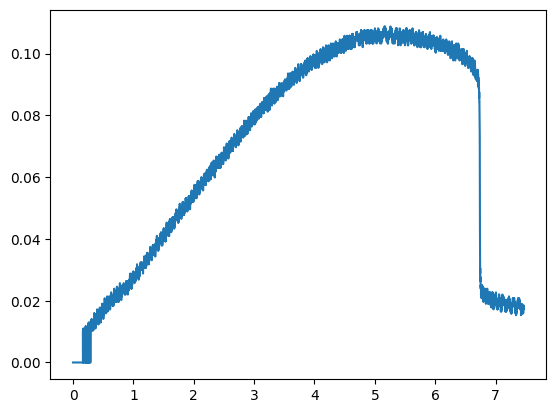

In [124]:
plt.plot(df1["변위"],df1["하중"])
plt.show()

In [125]:
import numpy as np
from scipy.signal import savgol_filter


arr = np.vstack([df1["변위"].values, df1["하중"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)

[[8.49417249e-04 1.42400932e-03 2.05594406e-03 ... 7.46935268e+00
  7.46966457e+00 7.46990629e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.80419580e-02
  1.80139860e-02 1.79580420e-02]]


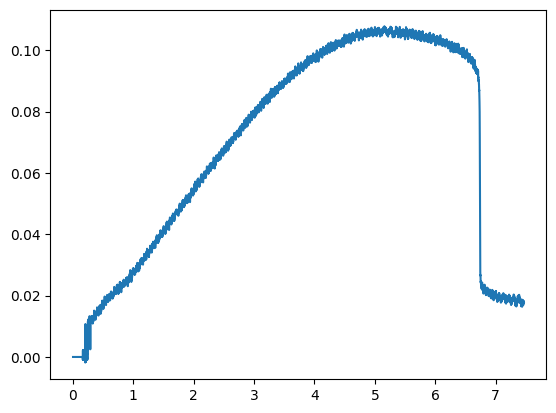

In [126]:
plt.plot(arr_smooth[0,:],arr_smooth[1,:])

In [127]:
print(len(arr_smooth[0]))

18830


In [128]:
Y = arr_smooth[1]
X = arr_smooth[0]

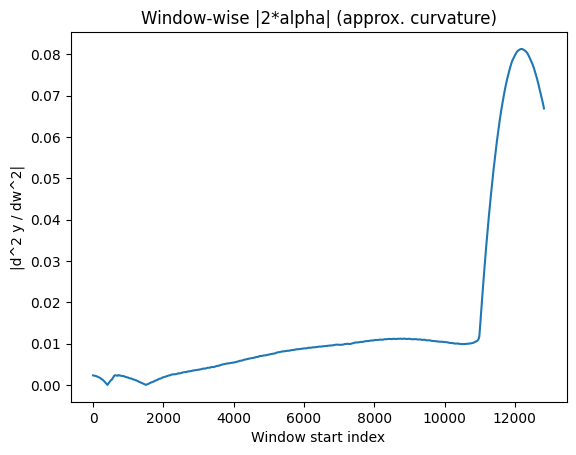

Best window start: 1498


In [129]:
#이때 아래와 같이 최적화 문제를 정의할 수 있다.
#Toe compensation를 하려면  가장 가파른 초기 직선 구간을 찾아야 한다.
#하지만 위 데이터에서는 순간적인 기울기(미분)을 구한다면 노이즈가 들어가 이를 계산하기 어려워진다.

#이를 해결하기 위해 least squares에 기반하여 window 창 크기 m에 대해서 가장 l2 norm을 minimization하면 된다.

#이때 vector는 [a,b]이며 각각 aw + b를 나타낸다.

#계측 벡터는 y이며 하중이다.

#입력 벡터는 w이며 변위이다.


Y = arr_smooth[1].astype(float)
W = arr_smooth[0].astype(float)

if not np.all(np.diff(W) >= 0):
    idx = np.argsort(W)
    W, Y = W[idx], Y[idx]

m = 6000  # 창 크기
curv = []   # 각 창의 이차미분 값(= 2*alpha)
betas = []  # (alpha, beta, gamma) 저장(필요시)
starts = [] # 창 시작 인덱스 기록

for i in range(len(Y) - m + 1):
    y = Y[i:i+m]
    w = W[i:i+m]

    # 2차 다항 최소제곱법 적용
    X = np.column_stack([w**2, w, np.ones_like(w)])
    coef, *_ = np.linalg.lstsq(X, y, rcond=None)  # coef = [alpha, beta, gamma]
    alpha, beta, gamma = coef

    curv.append(2.0 * alpha)   # 곡률
    betas.append((alpha, beta, gamma))
    starts.append(i)

curv = np.array(curv)
starts = np.array(starts)

# 시각화: 곡률 절댓값이 작을수록 더 '직선'에 가까움
plt.figure()
plt.plot(np.abs(curv))
plt.title("Window-wise |2*alpha| (approx. curvature)")
plt.xlabel("Window start index")
plt.ylabel("|d^2 y / dw^2|")
plt.show()

# 가장 선형(곡률 최소) 창 선택
best_idx = np.argmin(np.abs(curv))
i0 = starts[best_idx]
alpha, beta, gamma = betas[best_idx]

y_win = Y[i0:i0+m]
w_win = W[i0:i0+m]
X_lin = np.column_stack([w_win, np.ones_like(w_win)])   # y ≈ a w + b
(a_lin, b_lin), *_ = np.linalg.lstsq(X_lin, y_win, rcond=None)


print(f"Best window start: {i0}")


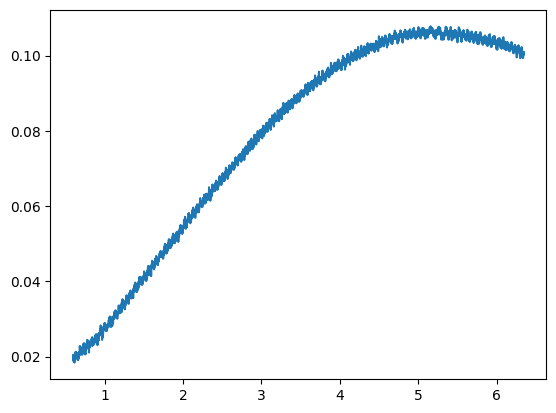

In [130]:
plt.plot(arr_smooth[0, i0:16000],arr_smooth[1, i0:16000])

최적화 시작...
최적화 완료! (소요 시간: 109.67초)

--- 최종 결과 ---
  찾은 첫 번째 접점 c1 = 1.1710
  찾은 두 번째 접점 c2 = 2.6753
  - 구간 1 (Linear):   m1 = 0.0240, b1 = 0.0041
  - 구간 2 (Linear):   m2 = 0.0262
  - 구간 3 (Quadratic): a3 = -0.0050
  최소 오차(SSE): 0.0084


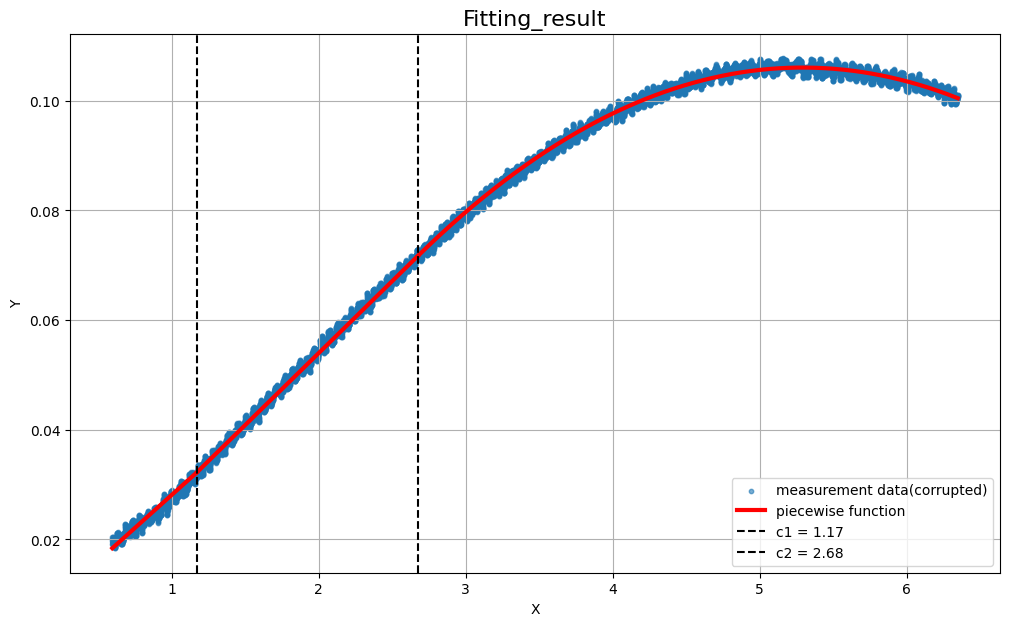

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time

def find_best_piecewise_fit(X, Y, c1_candidates=30, c2_candidates=30):
    """
    주어진 X, Y 데이터에 대해 최적의 조각별 함수(linear-linear-quadratic)를 탐색

    Args:
        X (np.array): 입력 데이터 (x축 값). 정렬(sorted) 필수
        Y (np.array): 측정 데이터 (y축 값).
        c1_candidates (int): 첫 번째 접점 후보의 개수.
        c2_candidates (int): 두 번째 접점 후보의 개수.

    Returns:
        dict: 찾은 최적의 파라미터(접점, 계수)와 최소 오차를 담은 딕셔너리.
    """
    if not np.all(np.diff(X) >= 0):
        print("경고: X 데이터가 정렬되어 있지 않습니다. 자동 정렬을 수행합니다.")
        sort_indices = np.argsort(X)
        X = X[sort_indices]
        Y = Y[sort_indices]

    print("최적화 시작...")
    start_time = time.time()


    data_range = X.max() - X.min()
    search_start = X.min() + data_range * 0.1
    search_end = X.max() - data_range * 0.1

    search_space_c1 = np.linspace(search_start, search_end - data_range * 0.2, c1_candidates)
    search_space_c2 = np.linspace(search_start + data_range * 0.2, search_end, c2_candidates)

    min_error = float('inf')
    best_params = {}

    # 격자 탐색 루프
    for c1 in search_space_c1:
        for c2 in search_space_c2:
            # 두 번째 접점은 첫 번째 접점보다 커야 함 (최소 간격 확보)
            if c2 <= c1 + data_range * 0.1:
                continue

            idx1 = X < c1
            idx2 = (X >= c1) & (X < c2)
            idx3 = X >= c2

            x_seg1, y_seg1 = X[idx1], Y[idx1]
            x_seg2, y_seg2 = X[idx2], Y[idx2]
            x_seg3, y_seg3 = X[idx3], Y[idx3]

            if len(x_seg1) < 2 or len(x_seg2) < 2 or len(x_seg3) < 2:
                continue

            m1 = cp.Variable()
            b1 = cp.Variable()
            m2 = cp.Variable()
            a3 = cp.Variable()

            # CVXPY 모델 정의 (연속성 조건 내장)
            y_pred1 = m1 * x_seg1 + b1
            f1_at_c1 = m1 * c1 + b1
            y_pred2 = m2 * (x_seg2 - c1) + f1_at_c1
            f2_at_c2 = m2 * (c2 - c1) + f1_at_c1
            y_pred3 = a3 * (x_seg3 - c2)**2 + m2 * (x_seg3 - c2) + f2_at_c2

            error = cp.sum_squares(y_pred1 - y_seg1) + \
                    cp.sum_squares(y_pred2 - y_seg2) + \
                    cp.sum_squares(y_pred3 - y_seg3)

            problem = cp.Problem(cp.Minimize(error))
            problem.solve(solver=cp.SCS) # cp.ECOS, cp.OSQP 등 다른 솔버 사용 가능

            if problem.status == 'optimal' and problem.value < min_error:
                min_error = problem.value
                best_params = {
                    'c1': c1, 'c2': c2,
                    'm1': m1.value, 'b1': b1.value,
                    'm2': m2.value, 'a3': a3.value,
                    'error': min_error
                }

    end_time = time.time()
    print(f"최적화 완료! (소요 시간: {end_time - start_time:.2f}초)")
    return best_params

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":

    Y_data = arr_smooth[1,i0:16000]
    X_data = arr_smooth[0,i0:16000]
    # ----------------------------------------------------------------------

    optimal_params = find_best_piecewise_fit(X_data, Y_data, c1_candidates=40, c2_candidates=40)

    ## 3. 결과 출력 및 시각화 ##
    print("\n--- 최종 결과 ---")
    if optimal_params:
        print(f"  찾은 첫 번째 접점 c1 = {optimal_params['c1']:.4f}")
        print(f"  찾은 두 번째 접점 c2 = {optimal_params['c2']:.4f}")
        print(f"  - 구간 1 (Linear):   m1 = {optimal_params['m1']:.4f}, b1 = {optimal_params['b1']:.4f}")
        print(f"  - 구간 2 (Linear):   m2 = {optimal_params['m2']:.4f}")
        print(f"  - 구간 3 (Quadratic): a3 = {optimal_params['a3']:.4f}")
        print(f"  최소 오차(SSE): {optimal_params['error']:.4f}")

        # 찾은 파라미터로 최종 함수 재구성
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit

        # 시각화
        plt.figure(figsize=(12, 7))
        plt.scatter(X_data, Y_data, s=10, alpha=0.6, label='measurement data(corrupted)')

        # 찾은 함수 플로팅
        plt.plot(x_fit1, y_fit1, 'r-', lw=3)
        plt.plot(x_fit2, y_fit2, 'r-', lw=3)
        plt.plot(x_fit3, y_fit3, 'r-', lw=3, label='piecewise function')

        # 접점 표시
        plt.axvline(x=c1, color='k', linestyle='--', label=f'c1 = {c1:.2f}')
        plt.axvline(x=c2, color='k', linestyle='--', label=f'c2 = {c2:.2f}')

        plt.title('Fitting_result', fontsize=16)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("최적의 해를 찾지 못했습니다. 데이터나 탐색 범위를 확인해주세요.")

In [132]:
print(f"Toe 영역= {optimal_params['c1']:.4f}")
print(f"추정 소성 변형 영역= {optimal_params['c2']:.4f}")

Toe 영역= 1.1710
추정 소성 변형 영역= 2.6753


In [133]:
m = optimal_params['m2']
L = 56 #mm
R= 1.4933 #크로스헤드 속도
d = 3.5 #mm
D = 7.4667 #최대 처짐률

In [134]:
print(m)

0.026237550772456895


In [135]:
import numpy as np


L = 56.0       # 지간 [mm]
d = 3.5        # 두께 [mm]
b = 13.05        # 폭 [mm]  <-- 시편 폭(mm) 넣어줘!
R_measured = 1.4933  # 크로스헤드 속도 [mm/min] (Procedure A 기대값과 같은지 체크)
D_5pct_given = 7.4667 # 5% 변형 한계 처짐(검산용) [mm]

m = 1000 * optimal_params['m2'] # [N/mm]

def flexural_modulus_from_m(m, L, b, d):
    """
    굽힘 탄성계수 E_B 계산 (MPa)
    공식: E_B = (L^3 * m) / (4 * b * d^3)  [N/mm^2 = MPa]
    """
    E = (L**3 * m) / (4.0 * b * d**3)  # 단위: MPa (N/mm^2)
    return E

E_from_given_m = flexural_modulus_from_m(m, L, b, d)  # MPa

print(f"[결과] E_from_given_m = {E_from_given_m:.2f} MPa  (={E_from_given_m/1000:.3f} GPa)")


[결과] E_from_given_m = 2058.79 MPa  (=2.059 GPa)


In [136]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from urllib.parse import quote

base = "https://raw.githubusercontent.com/imrealhelper/Aerospace_experiment_2/main/"
fname = "굽힘시험 수평 raw.csv"
url = base + quote(fname)

df1 = pd.read_csv(url, encoding="cp949")
df1 = df1.iloc[1:]
display(df1)


,일련번호,시간,하중,변위,테이블,강도,변형율
1,1.0,0.000,0.0000,0.000000,0.001900,0.0000,0.000000
2,2.0,0.011,0.0000,0.002300,0.002300,0.0000,0.001540
3,3.0,0.027,0.0000,0.002700,0.002700,0.0000,0.001808
4,4.0,0.044,0.0000,0.003000,0.003000,0.0000,0.002009
5,5.0,0.061,0.0000,0.003400,0.003400,0.0000,0.002277
...,...,...,...,...,...,...,...
18826,18826.0,301.523,0.1283,7.468600,7.468600,0.0687,5.001295
18827,18827.0,301.537,0.1283,7.469000,7.469000,0.0687,5.001562
18828,18828.0,301.554,0.1283,7.469400,7.469400,0.0687,5.001830
18829,18829.0,301.570,0.1289,7.469800,7.469800,0.0691,5.002098


In [137]:
df1["변위"] = df1["변위"].astype(float)
df1["하중"] = df1["하중"].astype(float)

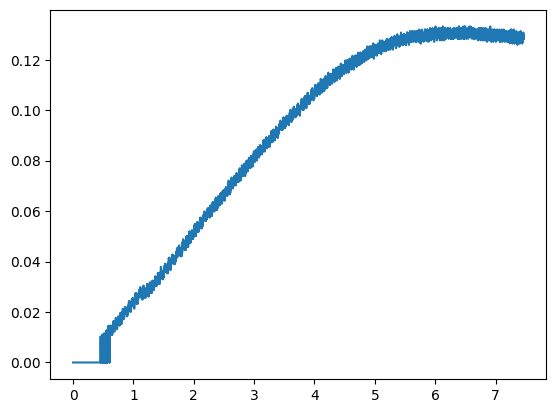

In [138]:
plt.plot(df1["변위"],df1["하중"])
plt.show()

In [139]:
import numpy as np
from scipy.signal import savgol_filter


arr = np.vstack([df1["변위"].values, df1["하중"].values])  # (2, N)
arr_smooth = savgol_filter(arr, 11, 3, axis=1, mode='nearest')
print(arr_smooth)

[[9.44755245e-04 1.56433566e-03 2.23659674e-03 ... 7.46944289e+00
  7.46976270e+00 7.47000420e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.28417483e-01
  1.28424476e-01 1.28417483e-01]]


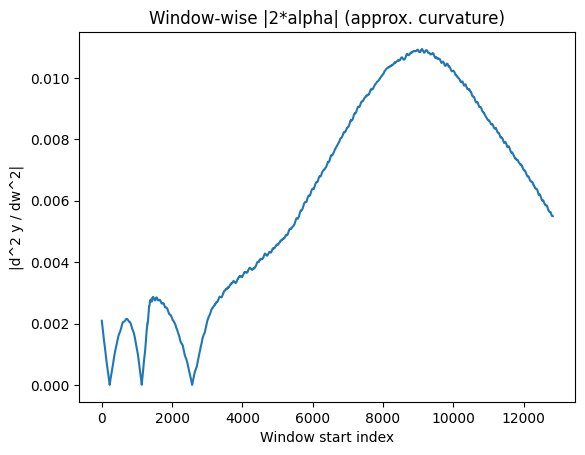

Best window start: 2570


In [140]:
#이때 아래와 같이 최적화 문제를 정의할 수 있다.
#Toe compensation를 하려면  가장 가파른 초기 직선 구간을 찾아야 한다.
#하지만 위 데이터에서는 순간적인 기울기(미분)을 구한다면 노이즈가 들어가 이를 계산하기 어려워진다.

#이를 해결하기 위해 least squares에 기반하여 window 창 크기 m에 대해서 가장 l2 norm을 minimization하면 된다.

#이때 vector는 [a,b]이며 각각 aw + b를 나타낸다.

#계측 벡터는 y이며 하중이다.

#입력 벡터는 w이며 변위이다.


Y = arr_smooth[1].astype(float)
W = arr_smooth[0].astype(float)

if not np.all(np.diff(W) >= 0):
    idx = np.argsort(W)
    W, Y = W[idx], Y[idx]

m = 6000  # 창 크기
curv = []   # 각 창의 이차미분 값(= 2*alpha)
betas = []  # (alpha, beta, gamma) 저장(필요시)
starts = [] # 창 시작 인덱스 기록

for i in range(len(Y) - m + 1):
    y = Y[i:i+m]
    w = W[i:i+m]

    # 2차 다항 최소제곱법 적용
    X = np.column_stack([w**2, w, np.ones_like(w)])
    coef, *_ = np.linalg.lstsq(X, y, rcond=None)  # coef = [alpha, beta, gamma]
    alpha, beta, gamma = coef

    curv.append(2.0 * alpha)   # 곡률
    betas.append((alpha, beta, gamma))
    starts.append(i)

curv = np.array(curv)
starts = np.array(starts)

# 시각화: 곡률 절댓값이 작을수록 더 '직선'에 가까움
plt.figure()
plt.plot(np.abs(curv))
plt.title("Window-wise |2*alpha| (approx. curvature)")
plt.xlabel("Window start index")
plt.ylabel("|d^2 y / dw^2|")
plt.show()

# 가장 선형(곡률 최소) 창 선택
best_idx = np.argmin(np.abs(curv))
i0 = starts[best_idx]
alpha, beta, gamma = betas[best_idx]

y_win = Y[i0:i0+m]
w_win = W[i0:i0+m]
X_lin = np.column_stack([w_win, np.ones_like(w_win)])   # y ≈ a w + b
(a_lin, b_lin), *_ = np.linalg.lstsq(X_lin, y_win, rcond=None)


print(f"Best window start: {i0}")

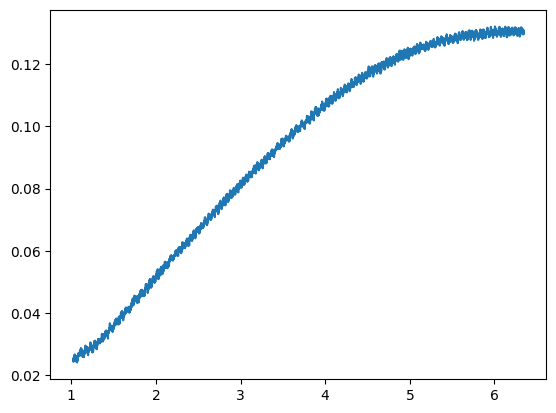

In [141]:
plt.plot(arr_smooth[0, i0:16000],arr_smooth[1, i0:16000])

최적화 시작...
최적화 완료! (소요 시간: 159.83초)

--- 최종 결과 ---
  찾은 첫 번째 접점 c1 = 1.5539
  찾은 두 번째 접점 c2 = 3.1108
  - 구간 1 (Linear):   m1 = 0.0267, b1 = -0.0036
  - 구간 2 (Linear):   m2 = 0.0299
  - 구간 3 (Quadratic): a3 = -0.0048
  최소 오차(SSE): 0.0087


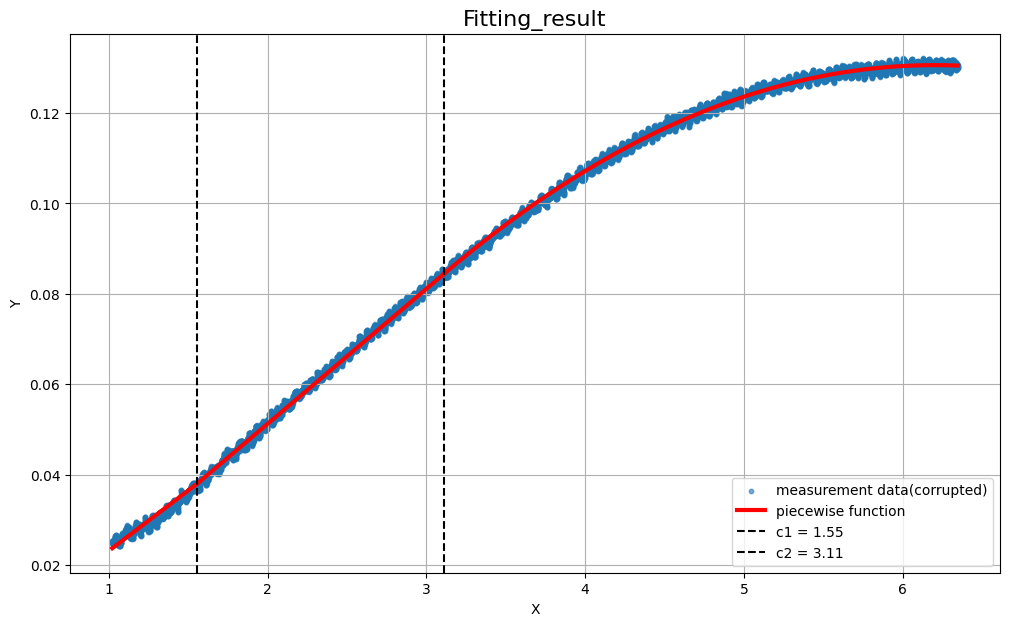

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import time

def find_best_piecewise_fit(X, Y, c1_candidates=30, c2_candidates=30):
    """
    주어진 X, Y 데이터에 대해 최적의 조각별 함수(linear-linear-quadratic)를 탐색

    Args:
        X (np.array): 입력 데이터 (x축 값). 정렬(sorted) 필수
        Y (np.array): 측정 데이터 (y축 값).
        c1_candidates (int): 첫 번째 접점 후보의 개수.
        c2_candidates (int): 두 번째 접점 후보의 개수.

    Returns:
        dict: 찾은 최적의 파라미터(접점, 계수)와 최소 오차를 담은 딕셔너리.
    """
    if not np.all(np.diff(X) >= 0):
        print("경고: X 데이터가 정렬되어 있지 않습니다. 자동 정렬을 수행합니다.")
        sort_indices = np.argsort(X)
        X = X[sort_indices]
        Y = Y[sort_indices]

    print("최적화 시작...")
    start_time = time.time()

    # 데이터 범위에 따라 접점(changepoint) 후보군 생성
    # 양 끝 10% 구간은 탐색에서 제외하여 안정성 확보
    data_range = X.max() - X.min()
    search_start = X.min() + data_range * 0.1
    search_end = X.max() - data_range * 0.1

    search_space_c1 = np.linspace(search_start, search_end - data_range * 0.2, c1_candidates)
    search_space_c2 = np.linspace(search_start + data_range * 0.2, search_end, c2_candidates)

    min_error = float('inf')
    best_params = {}

    # 격자 탐색 루프
    for c1 in search_space_c1:
        for c2 in search_space_c2:
            # 두 번째 접점은 첫 번째 접점보다 커야 함 (최소 간격 확보)
            if c2 <= c1 + data_range * 0.1:
                continue

            idx1 = X < c1
            idx2 = (X >= c1) & (X < c2)
            idx3 = X >= c2

            x_seg1, y_seg1 = X[idx1], Y[idx1]
            x_seg2, y_seg2 = X[idx2], Y[idx2]
            x_seg3, y_seg3 = X[idx3], Y[idx3]

            if len(x_seg1) < 2 or len(x_seg2) < 2 or len(x_seg3) < 2:
                continue

            m1 = cp.Variable()
            b1 = cp.Variable()
            m2 = cp.Variable()
            a3 = cp.Variable()

            # CVXPY 모델 정의 (연속성 조건 내장)
            y_pred1 = m1 * x_seg1 + b1
            f1_at_c1 = m1 * c1 + b1
            y_pred2 = m2 * (x_seg2 - c1) + f1_at_c1
            f2_at_c2 = m2 * (c2 - c1) + f1_at_c1
            y_pred3 = a3 * (x_seg3 - c2)**2 + m2 * (x_seg3 - c2) + f2_at_c2

            error = cp.sum_squares(y_pred1 - y_seg1) + \
                    cp.sum_squares(y_pred2 - y_seg2) + \
                    cp.sum_squares(y_pred3 - y_seg3)


            constraints = [m2 >= m1]
            problem = cp.Problem(cp.Minimize(error), constraints)

            problem.solve(solver=cp.SCS) # cp.ECOS, cp.OSQP 등 다른 솔버 사용 가능

            if problem.status == 'optimal' and problem.value < min_error:
                min_error = problem.value
                best_params = {
                    'c1': c1, 'c2': c2,
                    'm1': m1.value, 'b1': b1.value,
                    'm2': m2.value, 'a3': a3.value,
                    'error': min_error
                }

    end_time = time.time()
    print(f"최적화 완료! (소요 시간: {end_time - start_time:.2f}초)")
    return best_params

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":

    Y_data = arr_smooth[1,i0:16000]
    X_data = arr_smooth[0,i0:16000]
    # ----------------------------------------------------------------------

    optimal_params = find_best_piecewise_fit(X_data, Y_data, c1_candidates=40, c2_candidates=40)

    ## 3. 결과 출력 및 시각화 ##
    print("\n--- 최종 결과 ---")
    if optimal_params:
        print(f"  찾은 첫 번째 접점 c1 = {optimal_params['c1']:.4f}")
        print(f"  찾은 두 번째 접점 c2 = {optimal_params['c2']:.4f}")
        print(f"  - 구간 1 (Linear):   m1 = {optimal_params['m1']:.4f}, b1 = {optimal_params['b1']:.4f}")
        print(f"  - 구간 2 (Linear):   m2 = {optimal_params['m2']:.4f}")
        print(f"  - 구간 3 (Quadratic): a3 = {optimal_params['a3']:.4f}")
        print(f"  최소 오차(SSE): {optimal_params['error']:.4f}")

        # 찾은 파라미터로 최종 함수 재구성
        c1, c2 = optimal_params['c1'], optimal_params['c2']
        m1, b1, m2, a3 = optimal_params['m1'], optimal_params['b1'], optimal_params['m2'], optimal_params['a3']

        x_fit1 = X_data[X_data < c1]
        y_fit1 = m1 * x_fit1 + b1

        x_fit2 = X_data[(X_data >= c1) & (X_data < c2)]
        y_fit2 = m2 * (x_fit2 - c1) + (m1 * c1 + b1)

        x_fit3 = X_data[X_data >= c2]
        f2_at_c2_fit = m2 * (c2 - c1) + (m1 * c1 + b1)
        y_fit3 = a3 * (x_fit3 - c2)**2 + m2 * (x_fit3 - c2) + f2_at_c2_fit

        # 시각화
        plt.figure(figsize=(12, 7))
        plt.scatter(X_data, Y_data, s=10, alpha=0.6, label='measurement data(corrupted)')

        # 찾은 함수 플로팅
        plt.plot(x_fit1, y_fit1, 'r-', lw=3)
        plt.plot(x_fit2, y_fit2, 'r-', lw=3)
        plt.plot(x_fit3, y_fit3, 'r-', lw=3, label='piecewise function')

        # 접점 표시
        plt.axvline(x=c1, color='k', linestyle='--', label=f'c1 = {c1:.2f}')
        plt.axvline(x=c2, color='k', linestyle='--', label=f'c2 = {c2:.2f}')

        plt.title('Fitting_result', fontsize=16)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("최적의 해를 찾지 못했습니다. 데이터나 탐색 범위를 확인해주세요.")

In [143]:
import numpy as np

L = 56.0       # 지간 [mm]
d = 3.5       # 두께 [mm]
b = 12.8        # 폭 [mm]
R_measured = 1.4933  # 크로스헤드 속도 [mm/min]
# 추정 초기 기울기
m = 1000 * optimal_params['m2'] # [N/mm]

def flexural_modulus_from_m(m, L, b, d):
    """
    굽힘 탄성계수 E_B 계산 (MPa)
    공식: E_B = (L^3 * m) / (4 * b * d^3)  [N/mm^2 = MPa]
    """
    E = (L**3 * m) / (4.0 * b * d**3)  # 단위: MPa (N/mm^2)
    return E

E_from_given_m = flexural_modulus_from_m(m, L, b, d)  # MPa

print(f"[결과] E_from_given_m = {E_from_given_m:.2f} MPa  (={E_from_given_m/1000:.3f} GPa)")

[결과] E_from_given_m = 2389.86 MPa  (=2.390 GPa)
